In [1]:
import sys
sys.path.append("../production/")

In [2]:
import numpy as np
from sim_handling import Simulation,loadSim, continue_from_file #uses ds7, both PDES leads to stable solution
from diffusionstuff7 import f0d,f1d,f2d, getsigmastep_2d

# for plotting
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.animation import PillowWriter
from matplotlib.ticker import FormatStrFormatter

#for handling large simulations writing/reading from disk
import os
#import csv
import psutil

In [3]:
%matplotlib widget

#set figsize to be big (12,12) inches
#rcParams['figure.figsize'] = 10,10

assymettric 2d growth

In [4]:
#load a simulation

#load the ablation with initial noise run
#test_2d_asym = loadSim('f2d_simulation_asymmetric250_200_500layers_center_reduction0.1_D_2_RK45_sigmamax_-0.01noisyinit_True.pkl')

#load the growth with initial noise run
#test_2d_asym = loadSim('f2d_simulation_asymmetric250_200_500layers_center_reduction0.1_D_2_RK45_sigmamax_0.2noisyinit_True.pkl')


In [5]:
#set up and run and plot a new simulation
test_2d_asym = Simulation(f2d, (500,500), method='RK45')

#turn on memory handling logic
test_2d_asym.mem_check = True
#test_2d_asym.memory_threshold = 100E9 #100GB - default

test_2d_asym.discretization_halt = False

#try a noisy simulation
test_2d_asym.noisy_init = False

#test_2d_asym.float_params['DoverdeltaX2'] *= 2 
test_2d_asym.layermax = 1000
#test_2d_asym.sigmastepmax= -0.01#ablation
test_2d_asym.sigmastepmax= 0.20 #growth
#test_2d_asym.center_reduction = 0.25
#test_2d_asym.deltaT *= 10 #increase time step to decrease number of steps saved

#_plot = test_2d_asym.plot(tot=True,completion=1)
#anim = test_2d_asym.animate(ice=True,surface=True, ret=True, focus_on_growth=True)

1D model for comparison (uses same parameters as above 2d model), graphing if it also reaching steady state

In [9]:
#create 1d sim and graph number of steps over time
#ss_1d = Simulation(f1d, (test_2d_asym.shape[0],), method=test_2d_asym.method, rtol=test_2d_asym.rtol)
ss_1d = Simulation(f1d, (500,), method=test_2d_asym.method, rtol=test_2d_asym.rtol)

ss_1d.float_params['DoverdeltaX2'] = test_2d_asym.float_params['DoverdeltaX2'] 
#ss_1d.layermax = test_2d_asym.layermax * 1.5 #make sure it reaches steady state
ss_1d.layermax = 500 #make sure it reaches steady state
ss_1d.sigmastepmax = test_2d_asym.sigmastepmax 
ss_1d.sigma0 = test_2d_asym.sigma0
ss_1d.center_reduction = test_2d_asym.center_reduction
ss_1d.deltaT = test_2d_asym.deltaT #increase time step to decrease number of steps saved?
ss_1d.noisy_init = test_2d_asym.noisy_init


In [10]:
#set the id 
my_id=['nx_'+str(ss_1d.shape[0]),str(ss_1d.layermax)+'layers',
                                'center_reduction'+str(ss_1d.center_reduction),  'D_2', ss_1d.method, 'sigmamax_'+str(ss_1d.sigmastepmax) +'noisyinit_'+str(ss_1d.noisy_init)]
my_filename = ''.join([i+'_' for i in my_id])

breaking because reached max number of layers grown%16.05 % 17.07 % 18.71 %23.02 % % %%28.37 % 29.27 % 29.54 %30.1 % % 31.32 %%% 33.95 %34.9 % %36.1 %37.72 %38.74 % 40.32 % 40.92 % 42.56 % 44.14 %44.74 %45.54 % % % 50.75 %51.3 % 51.34 % 51.35 % 51.93 % 52.36 % 52.38 % 56.93 % %% % 58.35 %59.16 %%59.98 % % 61.02 % % 61.78 %%62.33 %%63.01 %63.78 %%64.22 % 66.21 % 67.36 % 67.37 % % 67.6 %%68.0 % 68.18 %68.2 %68.35 % 68.37 %71.6 % 72.22 % 72.78 % 73.02 % 73.38 % 73.39 % 74.39 % % 75.99 % 76.47 %% 76.65 % % %79.18 %79.81 %81.02 % 81.79 %%83.08 %% 84.96 %% 85.36 % 87.12 % 87.22 %87.24 % 87.45 %87.84 % % 89.02 %%89.58 %91.02 %91.43 % 91.78 %% 93.23 % %95.39 % % %% 98.43 % % % 99.7 %


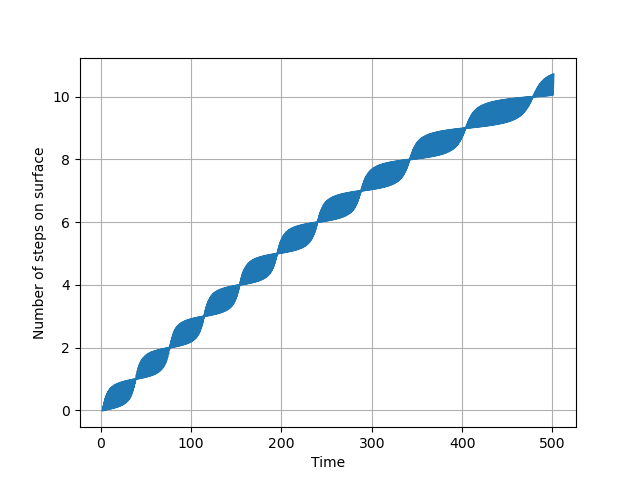

In [11]:
# plot number of steps over time
fignum = 0
plt.close(fignum)

Ntot = ss_1d.getNtot()

maxes = np.array([np.max(n) for n in Ntot[:]])
mins = np.array([np.min(n) for n in Ntot[:]])

#print(maxes,mins)
plt.figure(fignum)
ax = plt.subplot(111)

#ax.plot(test_f2d_sim.results()['t'],maxes-mins)
ax.plot(Ntot[:,0],maxes-mins)
ax.set_ylabel('Number of steps on surface')
ax.set_xlabel('Time')
plt.grid()
plt.show()

500 3311
(3311, 500) (3311, 500) (3311, 500)


C:\Users\elsla\AppData\Local\Temp\ipykernel_14796\3352238865.py:25: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X=xs, Y=ys, Z=zs,  label='ice+QLL', cmap='viridis_r')


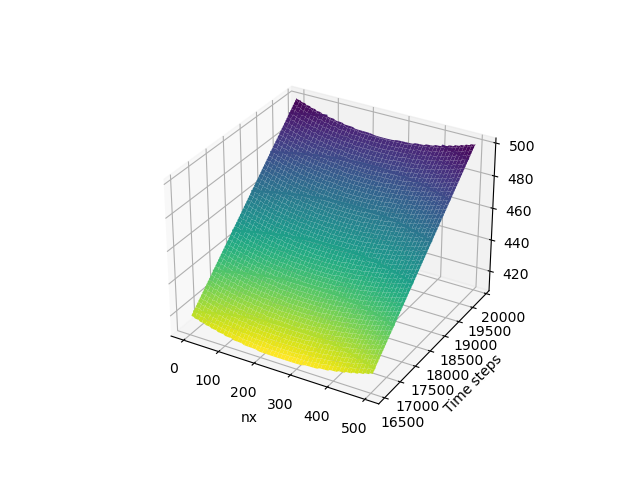

In [12]:
plt.close('1d surface over time 3d surface')
plt.figure('1d surface over time 3d surface')
#plot surface over time as 3d surface
ax = plt.axes(projection='3d')

#TODO:

zs = ss_1d.getNtot()
start,stop = 0, zs.shape[0]
#crop time selection
start,stop = stop*5//6, stop
zs = zs[start:stop]

t,x = [*zs.shape]
print(x,t)
xs,ys = np.meshgrid(np.linspace(0,x,x),np.linspace(start,stop,stop-start))

#print shapes of inputs
print(xs.shape,ys.shape,zs.shape)

#contour levels
levels = np.linspace(740,880,10)

#plot contours of the surface
ax.contour(X=xs, Y=ys, Z=zs,  label='ice+QLL', cmap='viridis_r')

#plot the surface with reversed viridis
ax.plot_surface(X=xs, Y=ys, Z=zs,  label='ice+QLL', cmap='viridis_r')

ax.set_xlabel('nx')
ax.set_ylabel('Time steps')
#ax.set_xlabel(r'x ($\mu m$)')
#ax.set_ylabel('Layers of ice')
plt.show()

500 19866
(19866, 500) (19866, 500) (19866, 500)


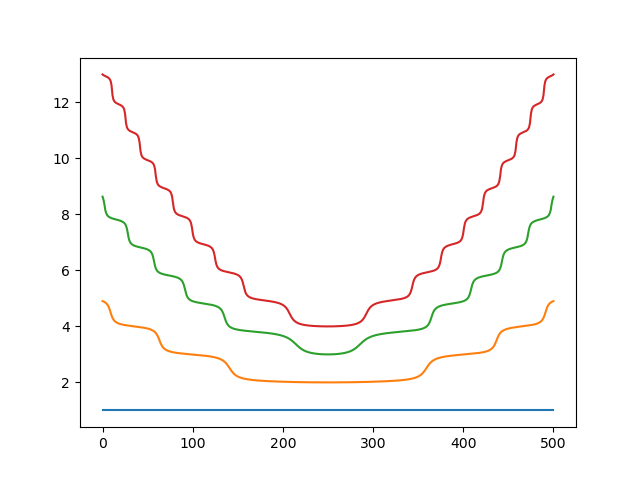

In [15]:
#plot contours over time on one surface
ax = plt.axes(projection='3d')

zs = ss_1d.getNtot()
start,stop = 0, zs.shape[0]
#crop time selection
#start,stop = stop*5//6, stop
zs = zs[start:stop]

t,x = [*zs.shape]
print(x,t)
xs,ys = np.meshgrid(np.linspace(0,x,x),np.linspace(start,stop,stop-start))

#print shapes of inputs
print(xs.shape,ys.shape,zs.shape)

# #contour levels
# levels = np.linspace(740,880,10)

# #plot the surface with reversed viridis
# ax.contour(X=xs, Y=ys, Z=zs,  label='ice+QLL', cmap='viridis_r')

# ax.set_xlabel('nx')
# ax.set_ylabel('Time steps')
# #ax.set_xlabel(r'x ($\mu m$)')
# #ax.set_ylabel('Layers of ice')
# plt.show()

ix = 100
plt.figure()

ixlist = [0, 4_000, 8_000, 16_000]#np.linspace(0,7400, 100)
offset = 1
for ix in ixlist:
    tempzs = zs[ix,:] - min(zs[ix,:]) + offset
    offset += 1
    plt.plot(xs[ix,:], tempzs,label = 'x = '+str(ix))

#plt.legend()

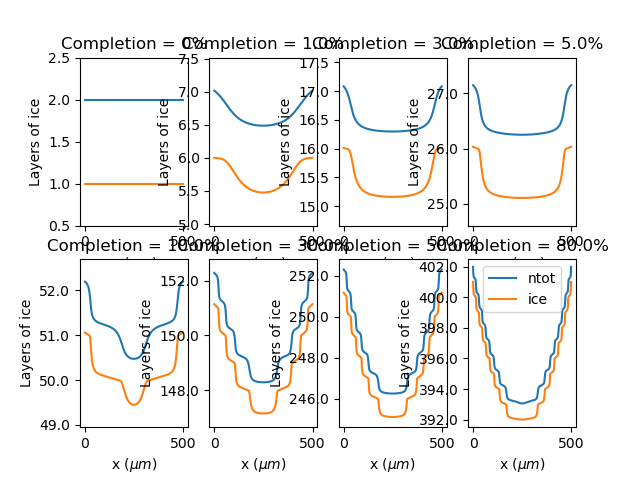

In [16]:
#plot the surface over time on subplots

#run the simulation
ntot = ss_1d.getNtot()
nice = ss_1d.getNice()

#plot the surface over time on subplots
fig, axs = plt.subplots(2, 4)
for i, cmpltion in enumerate([0,0.01,0.03,0.05,0.1,0.3,0.5,0.8]):
#for i, cmpltion in enumerate([0.1,0.12,0.15, 0.18,0.2,0.23,0.26,0.3]):

    xs = ntot[int(cmpltion*ntot.shape[0]),:]
    ice = nice[int(cmpltion*nice.shape[0]),:]
    axs[i//4, i%4].set_xlabel(r'x ($\mu m$)')
    axs[i//4, i%4].set_ylabel('Layers of ice')
    axs[i//4, i%4].set_ylim(bottom=min(ice)-.5, top=max(xs)+.5)
    axs[i//4, i%4].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[i//4, i%4].set_title('Completion = '+str(cmpltion*100)+'%')
    axs[i//4, i%4].plot(xs, label='ntot')
    axs[i//4, i%4].plot(ice, label='ice')

plt.legend()
plt.show()

In [17]:
# import csv

# # Get x, xs, ice at steady state (for reference 1D system)
# xs = ntot[int(ntot.shape[0])-1, :]
# ice = nice[int(nice.shape[0])-1, :]

# # Generate the range of x values from -250 to 250
# x = range(-250, 251)

# # Create a list of lists containing x, xs, and ice values
# data = [[xi, xsi, icei] for xi, xsi, icei in zip(x, xs, ice)]

# # Write the data to a CSV file
# with open('data/output.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['x', 'ntot', 'nice'])  # Write header row
#     writer.writerows(data)  # Write data rows


FileNotFoundError: [Errno 2] No such file or directory: 'data/output.csv'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


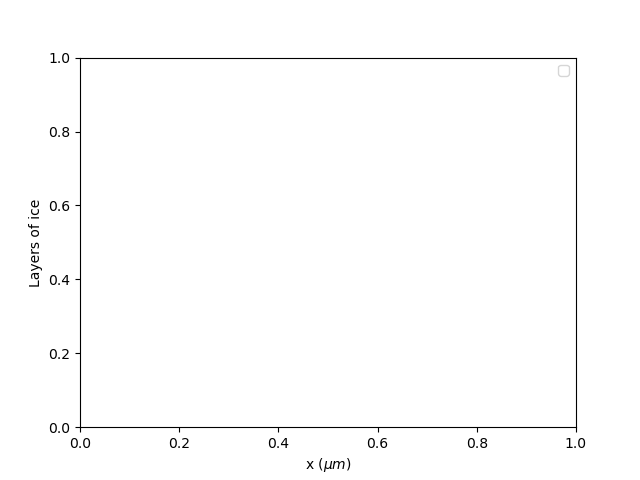

In [18]:
ss_1d.animate()

In [19]:
plt.close()


In [20]:
#test_2d_asym.save(id=['asymmetric'+str(test_2d_asym.shape[0])+'_'+str(test_2d_asym.shape[1]),str(test_2d_asym.layermax)+'layers'])
#symm = Simulation(f2d,(500,500),rtol=1e-12)

In [21]:
# #countour plot of sigmastep 2d
# plt.figure()
# ax = plt.axes(projection='3d')
# plt.xlabel(r'x ($\mu m$)')
# plt.ylabel(r'y ($\mu m$)')
# #ax.set_zlabel('Layers of ice')
# #levels = np.arange(19,21,0.1)
# ax.contourf(xgrid,ygrid, sigma*100, extent=(0, 2, 0, 2), cmap='YlGnBu_r', vmin=0, vmax=200, zorder=1)#, levels=levels)

In [22]:
# #countour plot of sigmastep 2d
# print(xs.shape,ys.shape,sigma.shape)
# fig,ax = plt.subplots()
# CS = ax.contourf(xs.T,ys.T,sigma*100)
# ax.set_xlabel(r'$x (\mu m)$', fontsize=20)
# ax.set_ylabel(r'$y (\mu m)$', fontsize=20)
# plt.grid(True)
# plt.gca().set_aspect('equal')
# fig.colorbar(CS)
# plt.title('%supersaturation (getsigmastep_2d)')

0D model for comparison (uses same parameters as above 2d model)

In [23]:
#create 1d sim and graph number of steps over time
#ss_1d = Simulation(f1d, (test_2d_asym.shape[0],), method=test_2d_asym.method, rtol=test_2d_asym.rtol)
ss_0d = Simulation(f0d, (1,), method=test_2d_asym.method, rtol=test_2d_asym.rtol)

# NOTE: 0d ablation sim halting is not implemented...
ss_0d.uselayers = False
ss_0d.countermax = 1750 #about 10 layers

ss_0d.float_params['DoverdeltaX2'] = test_2d_asym.float_params['DoverdeltaX2'] 
#ss_1d.layermax = test_2d_asym.layermax * 1.5 #make sure it reaches steady state
ss_0d.layermax = 10 
#ss_0d.sigmastepmax = test_2d_asym.sigmastepmax 
ss_0d.sigmastepmax = -0.01
ss_0d.sigma0 = test_2d_asym.sigma0
ss_0d.center_reduction = test_2d_asym.center_reduction
ss_0d.deltaT = test_2d_asym.deltaT #increase time step to decrease number of steps saved?
ss_0d.noisy_init = test_2d_asym.noisy_init

In [24]:
print(ss_0d.sigmastepmax)
print(ss_0d.sigma0)

-0.01
0.19


In [25]:
#run the sim, get results
#nice_0d = ss_0d.getNice() #NOTE: current version of getNice() returns a 2d array
ntot_0d = ss_0d.getNtot()
fliq_0d = ss_0d.getFliq()
nice_0d = ntot_0d - fliq_0d

breaking because reached max number of iterations % % 8.4 %8.63 %9.94 % 10.57 % 12.57 % 15.26 % 16.8 %17.31 % 19.37 %21.2 % 22.23 % 24.29 %26.0 % 26.63 % 29.37 % 32.51 % 36.74 %% 40.46 % 42.69 %% 46.4 % 48.23 %49.2 % 50.46 % % %55.66 % 56.8 %%% 64.4 %%67.03 % 68.0 %68.57 % 69.43 %72.91 % % 77.31 % 78.34 % 78.69 %%83.66 % 90.97 % %


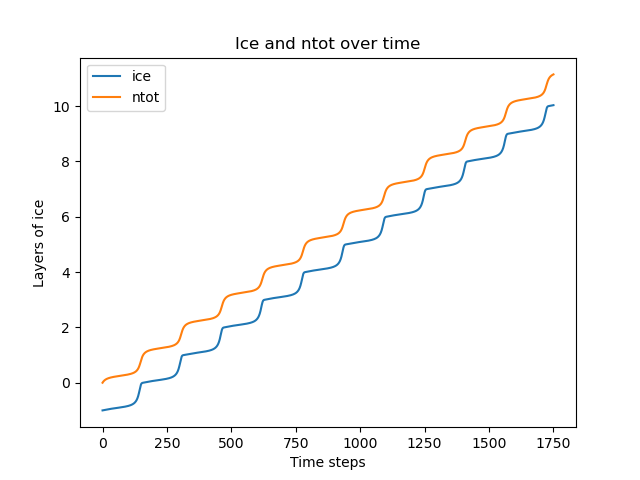

In [26]:
#plot ice and ntot over time
fig = plt.figure()
ax = plt.axes()
ax.set_xlabel('Time steps')
ax.set_ylabel('Layers of ice')
ax.set_title('Ice and ntot over time')
ax.plot(nice_0d, label='ice')
ax.plot(ntot_0d, label='ntot')
plt.legend()
plt.show()

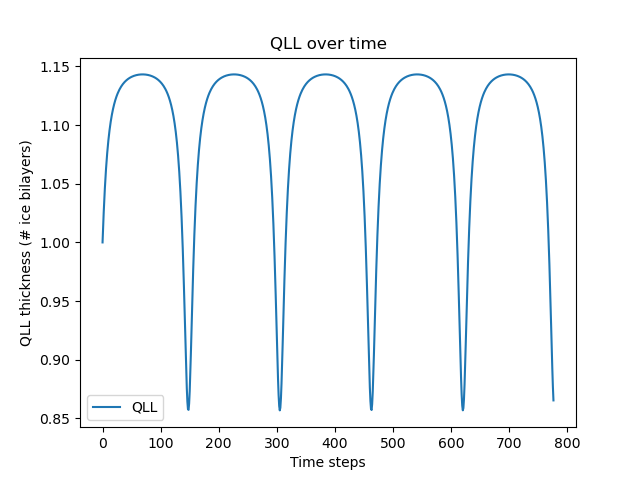

In [27]:
#plot QLL over time (illustrates microsurfaces), diffusive slowdown
fig = plt.figure()
ax = plt.axes()
ax.set_xlabel('Time steps')
ax.set_ylabel('QLL thickness (# ice bilayers)')
ax.set_title('QLL over time')
ax.plot(fliq_0d[:777], label='QLL')
plt.legend()
plt.show()


2D Growth simulation

In [ ]:
# #create the 2d sim
# test_f2d_sim = Simulation(f2d, (250,250), rtol=1e-12)
# test_f2d_sim.layermax = 50#0
# #test_f2d_sim.run()
# #test_f2d_sim.save(_id=['test','50layer'])

In [ ]:
# #animate the 2d sim
# test_f2d_sim.animate(crossSection=True)

In [ ]:
# #print variables in 1d simulation for comparison to literature
# for k,v in test_f2d_sim._extra_vars.items():
#     print(k,v)
# print('center reduction %: ', test_f2d_sim.center_reduction)

In [ ]:
# #print number of steps over time
# Ntot = test_f2d_sim.getNtot()

# maxes = np.array([np.max(n) for n in Ntot[:]])
# mins = np.array([np.min(n) for n in Ntot[:]])

# #print(maxes,mins)
# plt.figure()
# ax = plt.subplot(111)

# #ax.plot(test_f2d_sim.results()['t'],maxes-mins)
# ax.plot(Ntot[:,0,0],maxes-mins)
# #ax.plot(test_f2d_sim.results()['t'],test_f2d_sim.results()['t'])
# plt.grid()

In [ ]:
# #animate test_f2d_sim

# test_f2d_sim.animate(ice=True)

In [ ]:
#test_f2d_sim = loadSim('f2d_simulation_test_50layer.pkl') 

In [ ]:
# #graph results normalized to minimum of ice surface
# Fliq_ss, Ntot_steadystate = test_f2d_sim.normalize_results_to_min()
# nice_ss = Ntot_steadystate-Fliq_ss
# print(np.shape(Ntot_steadystate))
# xs, ys = np.meshgrid(test_f2d_sim.x, test_f2d_sim.y)

# fig = plt.figure(figsize=(12,12))
# ax = plt.axes(projection = '3d')
# #ax.plot_surface(test_f2d_sim._results['t'], Ntot_steadystate[:,])
# ax.set_xlabel(r'$x (\mu m$)')#,fontsize=fontsize)
# ax.set_ylabel(r'$y (\mu m$)')#,fontsize=fontsize)
# ax.set_zlabel(r'$ice \ layers$')#,fontsize=fontsize)
# #limits
# #ax.set_zlim3d(-self.layermax, self.layermax)
# #ax.set_ylim(0, max(self.y))
# #ax.set_xlim(0, max(self.x))
# def update_fig(num):
#     ax.clear() # remove last iteration of plot 
#     plot_func = ax.plot_surface
#     # if crossSection:
#     #     xmid = round(np.shape(Nice)[0]/2)
#     #     if ice:
#     #         plot_func(X=xs[xmid:], Y=ys[xmid:], Z=nice_ss[num][xmid:][:],cmap ='viridis')# cmap='viridis')#, vmin=0, vmax=200) #plot half of the surface of the ice
#     #     if tot:
#     #         plot_func(X=xs[xmid:], Y=ys[xmid:], Z=Ntot_steadystate[num][xmid:][:], cmap='cividis')#, vmin=0, vmax=200) #plot half the surface of the QLL
#     # else:
#     #     if ice:
#     plot_func(X=xs, Y=ys, Z=nice_ss[num], cmap='viridis')#, vmin=0, vmax=200) #plot the surface of the ice 
#         # if tot:
#     # plot_func(X=xs, Y=ys, Z=Ntot_steadystate[num], cmap='YlGnBu_r')#, vmin=0, vmax=200)#plot the surface of the QLL
#     pass


# num_steps = len(test_f2d_sim._results['t'])
# import matplotlib.animation as animation
# ani = animation.FuncAnimation(fig , update_fig, num_steps, interval=50, blit=False, cache_frame_data=False, repeat = True)
# plt.show()

In [ ]:
# #graph difference in steps over time: should converge to zero if steady state is reached
# Fliq_ss, Ntot_steadystate = test_f2d_sim.steady_state_calc()
# nice_ss = Ntot_steadystate-Fliq_ss
# print(np.shape(Ntot_steadystate))
# xs, ys = np.meshgrid(test_f2d_sim.x, test_f2d_sim.y)

# fig = plt.figure(figsize=(12,12))
# ax = plt.axes(projection = '3d')
# #ax.plot_surface(test_f2d_sim._results['t'], Ntot_steadystate[:,])
# ax.set_xlabel(r'$x (\mu m$)')#,fontsize=fontsize)
# ax.set_ylabel(r'$y (\mu m$)')#,fontsize=fontsize)
# ax.set_zlabel(r'$ice \ layers$')#,fontsize=fontsize)
# #limits
# #ax.set_zlim3d(-self.layermax, self.layermax)
# #ax.set_ylim(0, max(self.y))
# #ax.set_xlim(0, max(self.x))
# def update_fig(num):
#     ax.clear() # remove last iteration of plot 
#     plot_func = ax.plot_surface
#     # if crossSection:
#     #     xmid = round(np.shape(Nice)[0]/2)
#     #     if ice:
#     #         plot_func(X=xs[xmid:], Y=ys[xmid:], Z=nice_ss[num][xmid:][:],cmap ='viridis')# cmap='viridis')#, vmin=0, vmax=200) #plot half of the surface of the ice
#     #     if tot:
#     #         plot_func(X=xs[xmid:], Y=ys[xmid:], Z=Ntot_steadystate[num][xmid:][:], cmap='cividis')#, vmin=0, vmax=200) #plot half the surface of the QLL
#     # else:
#     #     if ice:
#     plot_func(X=xs, Y=ys, Z=nice_ss[num], cmap='viridis')#, vmin=0, vmax=200) #plot the surface of the ice 
#         # if tot:
#     # plot_func(X=xs, Y=ys, Z=Ntot_steadystate[num], cmap='YlGnBu_r')#, vmin=0, vmax=200)#plot the surface of the QLL
#     pass


# num_steps = len(test_f2d_sim._results['t'])
# import matplotlib.animation as animation
# ani = animation.FuncAnimation(fig , update_fig, num_steps, interval=50, blit=False, cache_frame_data=False, repeat = True)
# plt.show()

In [ ]:
# test_2d_sim = Simulation(f2d, (500,500), rtol=1e-12)
# test_2d_sim.layermax = 2
# #test_2d_sim = loadSim('f2d_simulation_august13.pkl')
# _plot = test_2d_sim.plot()

1d simulation 

In [ ]:
test_2d_sim.save(id=['august13'])

NameError: name 'test_2d_sim' is not defined

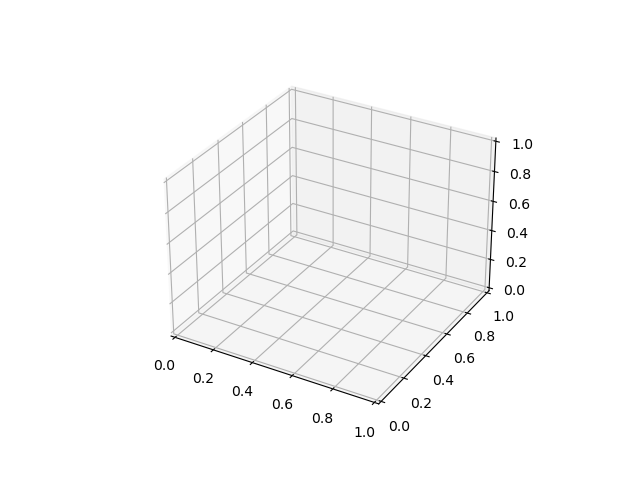

In [28]:
fig = plt.figure()
ax = plt.axes(projection='3d')
num_steps = len(test_2d_sim.results()['t'])
xs,ys = np.meshgrid(test_2d_sim.x, test_2d_sim.y)
ax.plot_surface(X=xs, Y=ys, Z=test_2d_sim.getNtot()[num_steps-1], cmap='viridis')

In [ ]:
test_1d = Simulation(f1d, shape=(500,), rtol=1e-12)
test_1d.layermax = 500
test_1d.results()

In [ ]:
#test_1d.animate(ice=True, tot=True)
test_1d.plot()

2d Idea: increase sigmastepmax to see if faceted growth occur, removing the concave "bowl" forming at the center of initially tested 2d systems (test_f2d_sim)

In [ ]:
# sigma_test = Simulation(f2d, (500,500),rtol = 1e-12)
# sigma_test.layermax = 100
# sigma_test.sigmastepmax = 0.25
# sigma_test.results()

In [ ]:
#sigma_id = ['sigmastepmax_'+str(round(100*sigma_test.sigmastepmax)), str(sigma_test.layermax)+'layers']
#sigma_test.save(id=sigma_id)

#test increased layers with increased sigmastep

#sigma_test = loadSim('f2d_simulation_sigmastepmax_025.pkl') # 20 layers?
#sigma_test = loadSim('f2d_simulation_sigmastepmax_025_50layers.pkl')
sigma_test = loadSim('f2d_simulation_sigmastepmax_25_100layers.pkl')

In [ ]:
sigma_test.animate()

2d Ablation testing

In [ ]:
f2d_ablate = Simulation(f2d, (500,500), rtol=1e-12)
f2d_ablate.sigmastepmax = -0.1
f2d_ablate.layermax = 50
f2d_ablate.animate()

1d growth testing. Works, however does not currently match the literature graph despite using the same parameters.

In [ ]:
f1d_sim = Simulation(f1d, (500,), rtol=1e-12)

In [ ]:
#change parameters to match Gladich et al paper's graph and run simulation
f1d_sim.layermax = 500#10000
#f1d_sim.center_reduction = 0.25 #is default now

In [ ]:
f1d_sim.run()

In [ ]:
fig = f1d_sim.plot(completion=0.99, ice=True, tot=True)

In [ ]:
#print variables in 1d simulation for comparison to literature
for k,v in f1d_sim._extra_vars.items():
    print(k,v)
print('center reduction %: ', f1d_sim.center_reduction)

In [ ]:
#functions tested so far
#test_f2d_sim.countermax_0D
#test_f2d_sim.countermax_1D
#test_f2d_sim.countermax_2D
#test_f2d_sim.atol
#test_f2d_sim.rtol
#test_f2d_sim.deltaT
#test_f2d_sim.float_params
#test_f2d_sim.animate()
#test_f2d_sim.run()
#test_f2d_sim.steady_state_calc()
#test_f2d_sim.plot()
#test_f2d_sim.save()
#test_f2d_sim.load() #WORKS to load simulation from file if simulation object exists already -- for loading straght froom file use loadSim()
#loadSim() #works



In [ ]:
num_steps = len(test_f2d_sim.results()['t'])
#shape of results is (num_steps, 2, nx, ny)
Fliq, Ntot = [],[]
for step in range(num_steps):
    next_Fliq, next_Ntot = test_f2d_sim._results['y'][step]
    Fliq.append(next_Fliq)
    Ntot.append(next_Ntot)    
Fliq,Ntot = np.array(Fliq), np.array(Ntot)
Nice = Ntot - Fliq
#shape of fliq, ntot and nice should be (num_steps, nx, ny)

#access coordinate arrays for plotting
xs, ys = np.meshgrid(test_f2d_sim.x, test_f2d_sim.y)

In [ ]:
print(num_steps)
print(test_f2d_sim.steepness(0,slice(0,test_f2d_sim.shape[0]//2)))

In [ ]:
print(test_f2d_sim.get_step_density(0,slice(0,test_f2d_sim.shape[0]//2)))  